In [1]:
import torch
from torchvision import transforms
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import pandas as pd

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau

import cv2


# Inspekting images

In [2]:
# Create a list of all the image filenames
IMG_PATH = "brain_tumor_dataset"
all_images = []
for folder in ['yes', 'no']:
    folder_path = os.path.join(IMG_PATH, folder)
    for filename in os.listdir(folder_path):
        
         all_images.append(os.path.join(folder_path, filename))

# Create a list of corresponding labels (0 for 'no', 1 for 'yes')
labels = [1 if 'Y' in filename else 0 for filename in all_images]

# Split the dataset into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(all_images, labels, test_size=0.05, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


In [15]:
pd.Series(y_train).value_counts()

1    108
0     72
dtype: int64

In [16]:
pd.Series(y_val).value_counts()

1    42
0    18
dtype: int64

In [17]:
pd.Series(y_test).value_counts()

0    8
1    5
dtype: int64

The samples are a bit unbalanced in general, validation set. There are more "yes" cases than "no" caeses. However, in the test set this distribution is reversed, which probably causes the model to perform worse on the test set compared to the validation set if the model learns to overpredict "yes". 

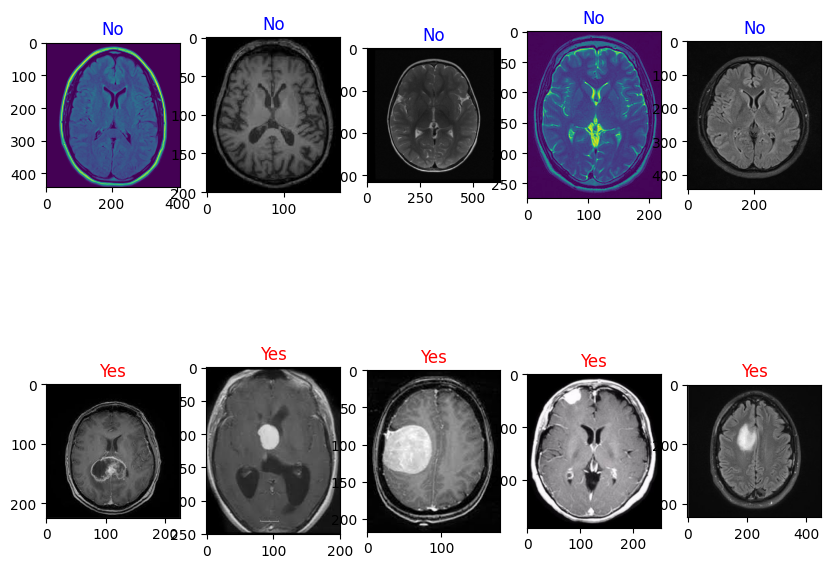

In [3]:
# Define the labels and their corresponding colors
labels = {0: 'No', 1: 'Yes'}
colors = {0: 'blue', 1: 'red'}

# Plot some images from the train set for each label
fig, axs = plt.subplots(2, 5, figsize=(10, 8))
for i, label in enumerate([0, 1]):
    images = [x for x, y in zip(X_train, y_train) if y == label][:5]
    for j, image_path in enumerate(images):
        img = plt.imread(image_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(labels[label], color=colors[label])
plt.show()

Most images in the dataset is in grayscale, while some are colored. To normalize all images we need to apply grayscaling and resizing them to the same size and shape.

# Naive Approach

## Preprocessing and convert to tensor

In [28]:
def convertToTensor(path_list, image_size):
    convert_tensor = transforms.ToTensor( )
    gray_scale = transforms.Grayscale()
    first = True

    for path in path_list:
        image = Image.open(path)
        image = image.resize((image_size, image_size))
        image = gray_scale(image)
        
        tensor = convert_tensor(image).numpy()
        tensor = tf.convert_to_tensor(tensor)
        tensor = tf.transpose(tensor, perm=[2, 1, 0])
        if first:
            image_tensor = np.array([tensor])
            first = False
        else:
            image_tensor = np.concatenate((image_tensor, np.array([tensor])))
    return image_tensor

In [27]:
convert_tensor = transforms.ToTensor( )
gray_scale = transforms.Grayscale()
directory = 'no'
first = True

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        image = Image.open(f)
        image = image.resize((224,224))
        image = gray_scale(image)
        
        tensor = convert_tensor(image).numpy()
        tensor = tf.convert_to_tensor(tensor)
        tensor = tf.transpose(tensor, perm=[2, 1, 0])
        if first:
            no_images = np.array([tensor])
            no_labels = np.array([[0]])
            first = False
        else:
            no_images = np.concatenate((no_images, np.array([tensor])))
            no_labels = np.concatenate((no_labels, np.array([[0]])))


In [28]:
convert_tensor = transforms.ToTensor()
gray_scale = transforms.Grayscale()
directory = 'yes'
first = True

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        image = Image.open(f)
        image = image.resize((224,224))
        image = gray_scale(image)
        
        tensor = convert_tensor(image).numpy()
        tensor = tf.convert_to_tensor(tensor)
        tensor = tf.transpose(tensor, perm=[2, 1, 0])
        if first:
            yes_images = np.array([tensor])
            yes_labels = np.array([[1]])
            first = False
        else:
            yes_images = np.concatenate((yes_images, np.array([tensor])))
            yes_labels = np.concatenate((yes_labels, np.array([[1]])))

In [30]:
images = np.concatenate((no_images, yes_images))
labels = np.concatenate((no_labels, yes_labels))

In [62]:
train_val_images, test_images, train_val_labels, test_labels = train_test_split(images, labels, test_size = 0.05, random_state = 42)
train_images, val_images, train_labels, val_labels = train_test_split(train_val_images, train_val_labels, test_size = 0.25, random_state = 42)

train_images, test_images, val_images = train_images.astype("float32") / 255.0, test_images.astype("float32") / 255.0, val_images.astype("float32") / 255.0

In [66]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(1,activation = "sigmoid"))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 flatten_6 (Flatten)         (None, 173056)           

In [67]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(val_images, val_labels))

Epoch 1/10
6/6 [==============================] - 32s 3s/step - loss: 0.6833 - accuracy: 0.5889 - val_loss: 0.6982 - val_accuracy: 0.5333
Epoch 2/10
6/6 [==============================] - 7s 1s/step - loss: 0.6599 - accuracy: 0.6333 - val_loss: 0.7148 - val_accuracy: 0.5333
Epoch 3/10
6/6 [==============================] - 12s 2s/step - loss: 0.6600 - accuracy: 0.6333 - val_loss: 0.7207 - val_accuracy: 0.5333
Epoch 4/10
6/6 [==============================] - 6s 1s/step - loss: 0.6579 - accuracy: 0.6333 - val_loss: 0.7035 - val_accuracy: 0.5333
Epoch 5/10
6/6 [==============================] - 6s 977ms/step - loss: 0.6577 - accuracy: 0.6333 - val_loss: 0.7142 - val_accuracy: 0.5333
Epoch 6/10
6/6 [==============================] - 7s 1s/step - loss: 0.6584 - accuracy: 0.6333 - val_loss: 0.7018 - val_accuracy: 0.5333
Epoch 7/10
6/6 [==============================] - 6s 984ms/step - loss: 0.6565 - accuracy: 0.6333 - val_loss: 0.7257 - val_accuracy: 0.5333
Epoch 8/10
6/6 [=================

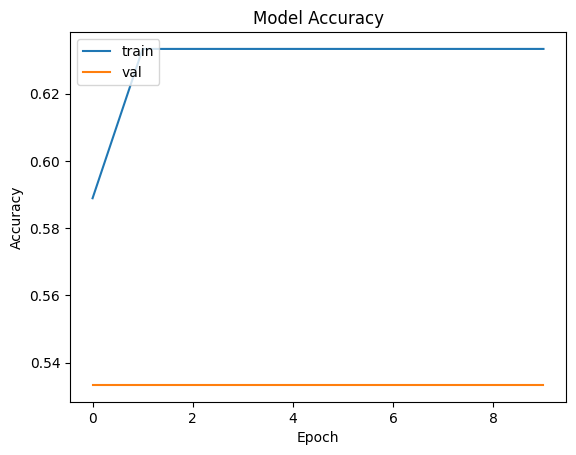

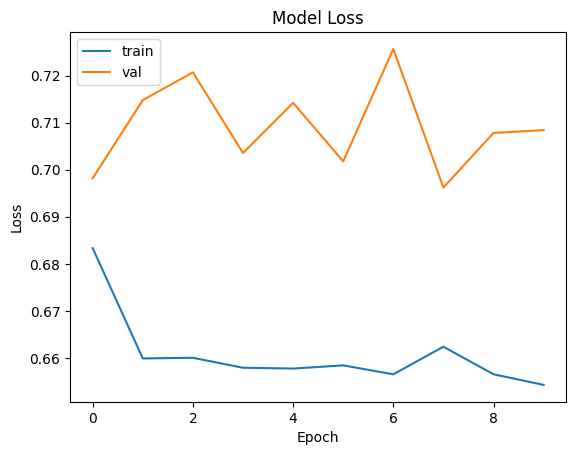

In [75]:
# Plot the training and validation accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 1s 561ms/step


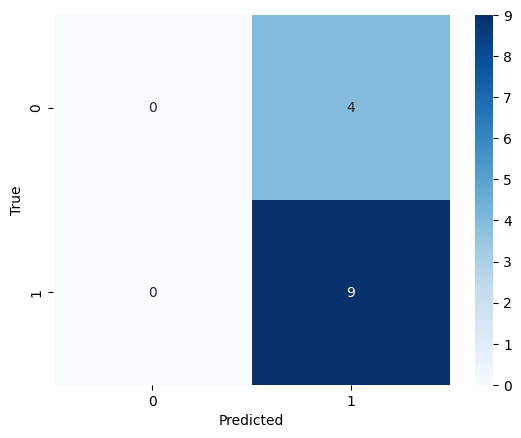

Test accuracy: 0.6923076923076923


In [74]:
y_pred = model.predict(test_images)
y_pred = np.round(y_pred).astype(int)

# Plot confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

cm = confusion_matrix(test_labels, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate accuracy on test set
test_accuracy = accuracy_score(test_labels, y_pred)
print('Test accuracy:', test_accuracy)

The model is terrible. It only predicts the majority category: Yes

# VVG19

## Preprocessing

Apply simple preprocessing that resizes each image to the same size cubic shape.

In [4]:
def proprocessing(path_list, image_size):
    images = []
    for path in path_list:
        image = cv2.imread(path)
        image = cv2.resize(image,
                           dsize = (image_size, image_size),
                           interpolation = cv2.INTER_CUBIC,
                           )
        images.append(image)
    return np.array(images)

Apply the preprocessing to each of the data splits

In [5]:
image_size = 224

X_train_pre = proprocessing(X_train, image_size)
X_test_pre = proprocessing(X_test, image_size)
X_val_pre = proprocessing(X_val, image_size= image_size)

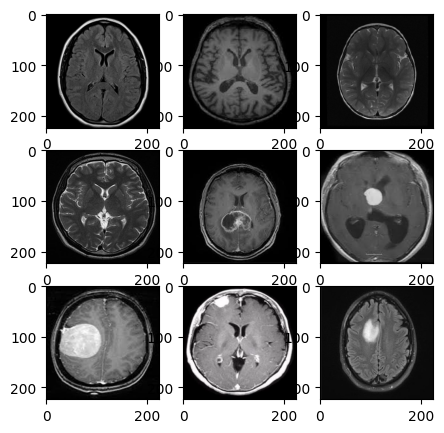

In [6]:
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train_pre[i], cmap = "gray")
plt.show()

Use VGG19 special preprocessing to the image

In [7]:
X_train_pre_vgg = np.array([preprocess_input(image) for image in X_train_pre])
X_val_pre_vgg = np.array([preprocess_input(image) for image in X_val_pre])
X_test_pre_vgg = np.array([preprocess_input(image) for image in X_test_pre])

We see that the preprocessing is highly effective in identifying removing noice, leaving cleare shapes of brain tumors.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


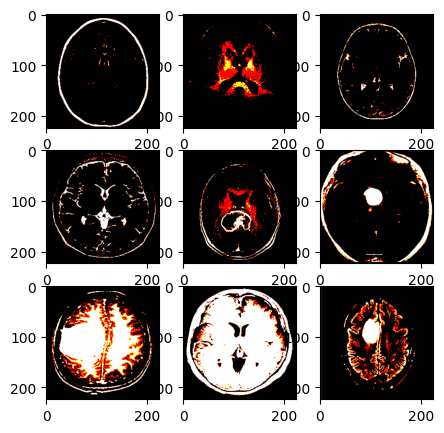

In [8]:
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train_pre_vgg[i], cmap = "gray")
plt.show()

## Modeling

Defining the pretrained model and adding a few layers on top

In [9]:
base_model = VGG19(
weights='imagenet',
include_top=False,
input_shape=(image_size, image_size, 3)
)

# Create a new model by adding a few layers on top of the pre-trained model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Freeze the weights of the pre-trained model
model.layers[0].trainable = False

# Compile the model with appropriate loss function, optimizer and metrics
model.compile(
loss='binary_crossentropy',
optimizer=Adam(),
metrics=['accuracy']
)

# Print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [10]:
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=20,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest'
)

# Create the training data generator using the training dataset and the data generator
train_generator = train_datagen.flow(
X_train_pre_vgg,
y_train,
batch_size=32
)

# Define the validation data generator with appropriate data preprocessing
val_datagen = ImageDataGenerator(rescale=1./255)

# Create the validation data generator using the validation dataset and the data generator
val_generator = val_datagen.flow(X_val_pre_vgg, y_val, batch_size=18)


## With 10 epochs

In [11]:
history = model.fit(
train_generator,
epochs = 10,
validation_data=val_generator
)

Epoch 1/10
6/6 [==============================] - 169s 25s/step - loss: 0.8858 - accuracy: 0.6056 - val_loss: 0.7670 - val_accuracy: 0.4167
Epoch 2/10
6/6 [==============================] - 98s 16s/step - loss: 0.7539 - accuracy: 0.6333 - val_loss: 0.3409 - val_accuracy: 0.9000
Epoch 3/10
6/6 [==============================] - 89s 15s/step - loss: 0.6354 - accuracy: 0.6556 - val_loss: 0.3078 - val_accuracy: 0.9000
Epoch 4/10
6/6 [==============================] - 91s 16s/step - loss: 0.5403 - accuracy: 0.7556 - val_loss: 0.3482 - val_accuracy: 0.8333
Epoch 5/10
6/6 [==============================] - 87s 15s/step - loss: 0.4582 - accuracy: 0.7389 - val_loss: 0.2857 - val_accuracy: 0.8667
Epoch 6/10
6/6 [==============================] - 90s 15s/step - loss: 0.4961 - accuracy: 0.7833 - val_loss: 0.3035 - val_accuracy: 0.8500
Epoch 7/10
6/6 [==============================] - 93s 16s/step - loss: 0.4613 - accuracy: 0.7944 - val_loss: 0.2918 - val_accuracy: 0.8500
Epoch 8/10
6/6 [==========

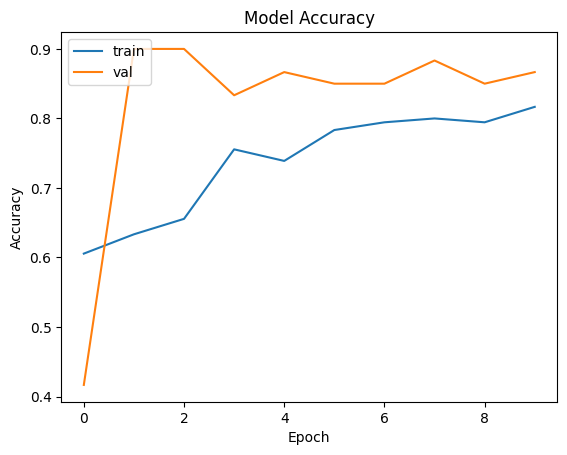

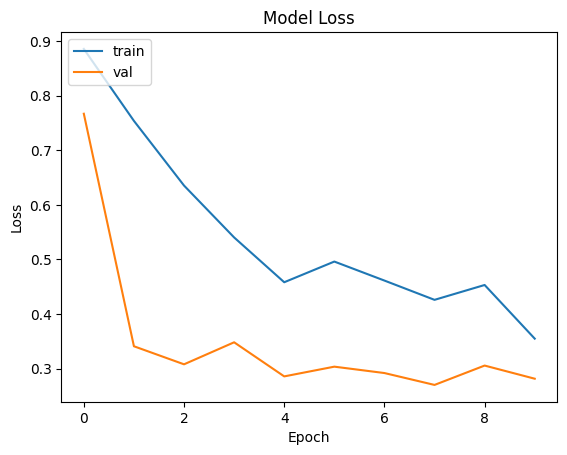

In [12]:
# Plot the training and validation accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The model performs better on the validation set than the traning set, which is due to the fact that the validation set is highly schewed in the favor of "yes" vs. "no" images. Since the training set is allready inblanced, the model learnes to predict more "yes" than no in genereal to improve it's accuracy. Judging from the training curves, there maight still be some improvement to gain in accuracy by running more epochs, but this might also overfit the model. 

In [14]:
y_test

[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]

1/1 [==============================] - 12s 12s/step


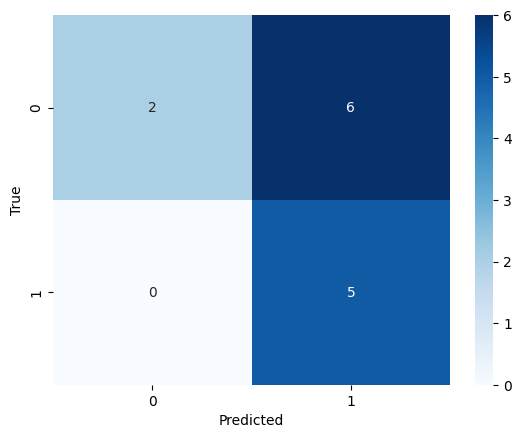

Test accuracy: 0.5384615384615384


In [13]:
y_pred = model.predict(X_test_pre_vgg)
y_pred = np.round(y_pred).astype(int)

# Plot confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate accuracy on test set
test_accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy:', test_accuracy)

Like the naive model, this model still mainly predict "yes". Fortunately, the model identified, correctly, two cases of 

## 50 epochs

In [18]:
history = model.fit(
train_generator,
epochs = 50,
validation_data=val_generator
)

Epoch 1/50


In [ ]:
# Plot the training and validation accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test_pre_vgg)
y_pred = np.round(y_pred).astype(int)

# Plot confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate accuracy on test set
test_accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy:', test_accuracy)